# TP1 Naive Bayes - Kieran Schubert - 11/03/19

## Theoretical setting
The Naive Bayes algorithm is a classification method which computes the Maximum A Posteriori probability of a class. Bayes Theorem states that $P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$ which can be interpreted as $Posterior = \frac{likelihood*prior}{evidence}$. In practice, we will only compute the numerator as the *evidence* is proportional to all classes. In this TP, we will compute the *posterior* probabilities of observing a class given the data (e.g. $P(Iris \_setosa|data)$ for the *Iris* dataset) as the product of the *likelihood* and the *prior*. The *prior* for each class is defined as $prior_i=\frac{\#class_i}{\#training\:examples}$, and the *likelihood* of a data point as $likelihood=P(x_i|class)= \prod_{i=1}^{p} P(x_{i}|class)$ since we assume the features are conditionally independent. We can then select the posterior with highest probability (MAP) to predict the most probable class for our new example. 

For the *Titanic* dataset, the data is categorical and the features are assumend to be conditionally independent. We can use frequencies to compute probabilities for the levels of each feature. In the case of the *Iris* dataset, we will first discretize the data and compute the MAP probability similarly to the *Titanic* case by assuming independence of the features. We then treat the features as continuous, normally distributed and also conditionally independent. We estimate the sample means and variances of each feature conditioning on class in the training set to obtain the probabilities for new data points in the test set. 

#### This section contains the functions for Naive Bayes classification on the *Iris* and *Titanic* datasets:

In [1]:
import numpy as np
import pandas as pd
import math
import random

In [2]:
############ CONTINUOUS DATA FUNCTIONS ############   

def return_labels(x):
    """This function takes a dataset as input and returns the classification labels, assuming the last column contains the labels"""
    labels = pd.unique(x.iloc[:,-1])
    return labels

def split_data_random(x, train_ratio):
    """This function takes a dataset and train_ratio as inputs and returns a training set and test set"""
    train_size = math.floor(x.shape[0]*train_ratio)
    ind = random.sample(range(x.shape[0]), train_size)
    train_set = x.iloc[ind, :]
    test_set = x.iloc[~x.index.isin(train_set.index)]
    return train_set, test_set

def split_by_class(train_set, labels):
    """This function takes a training set and labels as inputs and splits the training set into classes using the class labels"""
    split_dataset = {}
    for i in range(len(labels)):
        split_dataset[i] = train_set.loc[train_set.iloc[:,-1] == labels[i]]   
    return split_dataset

def mean_var_by_class(train_set, labels):
    """This function takes a training set and labels as inputs and returns the mean and variance for each class"""
    mean = np.zeros((len(labels), train_set.shape[1]-1))
    var = np.zeros((len(labels), train_set.shape[1]-1))
    split = split_by_class(train_set, labels)
    for i in range(len(labels)):
        mean[i] = split[i].mean()
        var[i] = split[i].var()
    return mean, var

def prior(train_set, labels):
    """This function takes a training set and labels as input and returns the prior probabilities based on the occurences in the training set"""
    pr = np.zeros(len(labels))
    for i in range(len(labels)):
        pr[i] = (train_set.iloc[:,-1] == labels[i]).sum() / train_set.shape[0]   
    return pr 

def normal_distr(x, mu, var):
    """This function takes a vector of data, a mean and variance as inputs and returns the normal distribution value"""
    normal_proba = (1/np.sqrt(2*np.pi*var))*np.exp((-(x-mu)**2)/(2*var))    
    return normal_proba   
 
def train_cont(x, train_ratio):
    """This function takes a continuous dataset and a training ratio as inputs and returns labels, a training set, a test set, the split datasets, the mean and variance of each class and the prior probabilites"""
    labels = return_labels(x)
    train_set, test_set = split_data_random(x, train_ratio)
    split_dataset = split_by_class(train_set, labels)
    mean, var = mean_var_by_class(train_set, labels)
    pr = prior(train_set, labels)
    return  labels, train_set, test_set, split_dataset, mean, var, pr
  
def posterior_cont(test_set, pr, mean, var, labels):
    """This function takes a training set, test set, prior probabilies, mean variance and labels and returns the posterior probability of observing a class given the (continuous) data"""
    normal_distr_vec = np.vectorize(normal_distr)
    post = np.zeros((len(labels)))
    for i in range(len(labels)):
        post[i] = np.prod([normal_distr_vec(test_set, mean[i,:], var[i,:])], axis=1)*pr[i]
    return post

def predict_class_cont(post):
    "This function takes posterior probabilities by class as input and returns a class prediction (for continuous data)"
    pred_class = np.argmax(post, axis=1)
    return pred_class
   
    
############ DISCRETE DATA FUNCTIONS ############   
    
    
def return_levels(train_set):
    """This function takes a training set as input and returns the levels of the categorical data"""
    levels = []
    for i in range(train_set.shape[1]-1):
        levels.append(pd.unique(train_set.iloc[:,i]))

    levels = np.concatenate(levels)
    return levels

def freq_by_class(split_dataset, levels):
    """This function takes a dataset split by class and levels as inputs and returns the discrete data frequencies for each class"""
    frequency_by_class = {}
    my_dict = {}
    for j in range(len(split_dataset.keys())):
        freq_class = []
        for col in range(split_dataset[j].shape[1]-1):
            levels = pd.unique(split_dataset[j].iloc[:,col])
            for i in range(len(levels)):
                x = (split_dataset[j].iloc[:,col] == levels[i]).sum() / split_dataset[j].shape[0]
                freq_class.append(x)
        frequency_by_class[j] = freq_class
    return frequency_by_class

def discr_probas(frequency_by_class, levels, labels):
    """This function takes the frequency by class, levels and data labels for discrete data and returns a dictionnary containing the probabilities of observing data"""
    probas = {}
    for j in range(len(frequency_by_class.keys())):
        freq_table = dict(list(enumerate(frequency_by_class[j])))
        for i in range(len(frequency_by_class[j])):
            freq_table[levels[i]] = freq_table.pop(i)
            probas[j] = freq_table
            probas[labels[j]] = probas.pop(j)
    return probas

def train_discr(x, train_ratio):
    """This function takes a dataset and a training ratio as inputs and returns labels, a training set, a test set, split datasets by class, prior probabilities based on the frequencies and discrete probabilites"""
    labels = return_labels(x)
    train_set, test_set = split_data_random(x, train_ratio)
    levels = return_levels(train_set)
    split_dataset = split_by_class(train_set, labels)
    pr = prior(train_set, labels)
    frequency_by_class = freq_by_class(split_dataset, levels)
    probas = discr_probas(frequency_by_class, levels, labels)
    return  labels, train_set, test_set, split_dataset, pr, probas

def posterior_discr(test_example, pr, labels, probas):
    "This function takes a test data example, prior probabilities, labels and discrete data probabilities as inputs and returns a posterior probability for discrete data"
    x = test_example
    cond_prob = np.zeros((len(labels), x.shape[0]))
    for k in range(len(labels)):
        for j in range(x.shape[0]):
            mykeys = [x.iloc[j]]
            freq_table = probas[labels[k]]
            try:
                cond_prob[k, [j]] = [freq_table[i] for i in mykeys]
            except KeyError:
                cond_prob[k, [j]] = 0
                
    post = np.multiply(pr, np.prod(cond_prob, axis=1))
    return post

def predict_class_discr(post):
    """This function takes a posterior probability of observing a class given data and returns a prediction of class"""
    pred_class = np.argmax(post, axis=1) #0 for individual ex, 1 for all test_set
    return pred_class

## Titanic dataset:

We start by setting the seed to reproduce results:

In [3]:
np.random.seed(42)

The titanic dataset is imported as a pandas dataframe. We see that there are p = 3 features (*class*, *age* and *sex*) and n = 2201 observations. The last column of the dataframe contains the classification labels.

In [4]:
titanic = pd.read_csv('/Users/kieranschubert/Desktop/Statistics/2nd Semester/Data Mining/2019/TP1 Naive Bayes/titanic.csv', sep=',')
print(titanic.head())
print(titanic.shape)

   class  age  sex  result
0  first  adu    m    surv
1  first  adu    m    surv
2  first  adu    m    surv
3  first  adu    m    surv
4  first  adu    m    surv
(2201, 4)


This dataset is categorical and each feature contains multiple levels. The *class* feature contains 4 levels (*first*, *second*, *third* and *crew*), the *age* feature contains 2 levels (*adulte* and *enfant*) and the *sex* feature contains 2 levels (*male* and *female*).

### Training phase:

In [5]:
levels = return_levels(titanic)
print(levels)

['first' 'second' 'third' 'crew' 'adu' 'enf' 'm' 'f']


We train our model by retrieving the labels, separating our data into a training set and a test set, splitting the dataset by class in order to compute the frequencies of data points as our data is not continuous. We also compute the prior probabilities based on our training set.

In [9]:
labels, train_set, test_set, split_dataset, pr, probas = train_discr(titanic, 0.67)

Once the model is trained, we want to make class predictions. We calculate the posterior probabilities for each class and select the Maximum a Posteriori value (the maximum probability of observing a class given the test data):

### Test phase:

In [10]:
post = np.zeros((test_set.shape[0], len(labels)))
for i in range(test_set.shape[0]):
    post[i, :] = posterior_discr(test_set.iloc[i, :-1], pr, labels, probas)
pred_class = predict_class_discr(post)

We now classify the whole test set and compute the missclassification rate. This rate fluctuates a bit since the training set is random but is between 20-30% most of the time. We also observe that the model has a tendency to classify many test instances as 'mort'. This might be due to the larger proportion of data labeled as 'mort' (priors) in the training set which creates a bias in classification.

In [11]:
test_set_pred = test_set.assign(predicted_class = pred_class)
test_set_pred = test_set_pred.replace(0, 'surv')
test_set_pred = test_set_pred.replace(1, 'mort')
missclass_rate = (test_set_pred.iloc[:,-2] != test_set_pred.iloc[:,-1]).sum() / test_set_pred.shape[0]
print('Missclassification rate = {}'.format(missclass_rate))
print(test_set_pred.head())

Missclassification rate = 0.23383768913342504
    class  age  sex  result predicted_class
3   first  adu    m    surv            mort
5   first  adu    m    surv            mort
7   first  adu    m    surv            mort
13  first  adu    m    surv            mort
17  first  adu    m    surv            mort


## Iris dataset:

In this part we treat the *Iris* data as being discrete (the realizations are treated as levels of a feature):

In [12]:
iris = pd.read_csv('/Users/kieranschubert/Desktop/Statistics/2nd Semester/Data Mining/2019/TP1 Naive Bayes/iris.csv', sep=',')
print(iris.head())
print(iris.shape)

   sepal_length   sepal_width   petal_length   petal_width        type.
0           5.1           3.5            1.4           0.2  Iris_setosa
1           4.9           3.0            1.4           0.2  Iris_setosa
2           4.7           3.2            1.3           0.2  Iris_setosa
3           4.6           3.1            1.5           0.2  Iris_setosa
4           5.0           3.6            1.4           0.2  Iris_setosa
(150, 5)


We see that the Iris dataset contains p = 5 features and the last column contains the labels. There are n = 150 observations.

In [13]:
print(iris.info())
print(pd.unique(iris.iloc[:,-1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length     150 non-null float64
 sepal_width     150 non-null float64
 petal_length    150 non-null float64
 petal_width     150 non-null float64
 type.           150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB
None
['Iris_setosa' 'Iris_versicolor' 'Iris_virginica']


The dataset is imported as a pandas dataframe. The numerical attributes are *sepal_length*, *sepal_width*, *petal_length* and *petal_width*. The categorical level is *type* and contains 3 levels: *Iris_setosa*, *Iris_versicolor* and *Iris_virginica*.

### Training phase:

In [14]:
levels = return_levels(iris)
print(levels)

[5.1 4.9 4.7 4.6 5.  5.4 4.4 4.8 4.3 5.8 5.7 5.2 5.5 4.5 5.3 7.  6.4 6.9
 6.5 6.3 6.6 5.9 6.  6.1 5.6 6.7 6.2 6.8 7.1 7.6 7.3 7.2 7.7 7.4 7.9 3.5
 3.  3.2 3.1 3.6 3.9 3.4 2.9 3.7 4.  4.4 3.8 3.3 4.1 4.2 2.3 2.8 2.4 2.7
 2.  2.2 2.5 2.6 1.4 1.3 1.5 1.7 1.6 1.1 1.2 1.  1.9 4.7 4.5 4.9 4.  4.6
 3.3 3.9 3.5 4.2 3.6 4.4 4.1 4.8 4.3 5.  3.8 3.7 5.1 3.  6.  5.9 5.6 5.8
 6.6 6.3 6.1 5.3 5.5 6.7 6.9 5.7 6.4 5.4 5.2 0.2 0.4 0.3 0.1 0.5 0.6 1.4
 1.5 1.3 1.6 1.  1.1 1.8 1.2 1.7 2.5 1.9 2.1 2.2 2.  2.4 2.3]


In [19]:
labels, train_set, test_set, split_dataset, pr, probas = train_discr(iris, 0.67)

### Test phase:

In [20]:
post = np.zeros((test_set.shape[0], len(labels)))
for i in range(test_set.shape[0]):
    post[i, :] = posterior_discr(test_set.iloc[i, :-1], pr, labels, probas)
pred_class = predict_class_discr(post)

In [21]:
print((post == 0).sum() / post.size)

0.9333333333333333


In [22]:
test_set_pred = test_set.assign(predicted_class = pred_class)
test_set_pred = test_set_pred.replace(0, 'Iris_setosa')
test_set_pred = test_set_pred.replace(1, 'Iris_versicolor')
test_set_pred = test_set_pred.replace(2, 'Iris_virginica')
missclass_rate = (test_set_pred.iloc[:,4] != test_set_pred.iloc[:,5]).sum() / test_set_pred.shape[0]
print('Missclassification rate = {}'.format(missclass_rate))
print(test_set_pred.head())

Missclassification rate = 0.62
   sepal_length   sepal_width   petal_length  petal_width        type.  \
0           5.1           3.5            1.4          0.2  Iris_setosa   
4           5.0           3.6            1.4          0.2  Iris_setosa   
5           5.4           3.9            1.7          0.4  Iris_setosa   
7           5.0           3.4            1.5          0.2  Iris_setosa   
8           4.4           2.9            1.4          0.2  Iris_setosa   

  predicted_class  
0     Iris_setosa  
4     Iris_setosa  
5     Iris_setosa  
7     Iris_setosa  
8     Iris_setosa  


We see that this method misclassifies roughly half of the test data. This is due to the fact that for some test set observations, the training set doesn't contain any similar "level" and thus the conditional probability is estimated to be 0 since there only needs to be one null element in the product to set the conditional probability to 0. We see that around 90% of the posterior probabilities are estimated to be 0. This behaviour is amplified by the small size of the dataset. One remedy would be to increase the available training data when possible. In the next part, we treat the data as being continuous and normally distributed.

## Training phase:
We start by identifying the labels of the data using the *return_labels* function. We then construct training and test sets by randomely sampling the original *Iris* dataset into a training set (2/3) and a test set (1/3) with the *split_data_random* function. We then compute the conditional mean $\mu(x_p|class_i)$ and conditional variance $\sigma^2(x_p|class_i)$ of each feature on the training set for each class (*split_by_class* and *mean_var_by_class* functions) and compute the prior probabilities (*prior* function). 

In [23]:
labels, train_set, test_set, split_dataset, mean, var, pr = train_cont(iris, 0.67)

## Test phase:

We then compute the posterior probabilities of observing a class given the data $P(class|x)$ which is proportional to $P(x|class_i)*P(class_i)$. The conditional probability can be obtained by assuming that the attributes are conditionally independent (hence the Naive Bayes name): $P(x|class) = \prod_{i=1}^{p} P(x_{i}|class)$ which is the likelihood (the joint density factors to the product of the marginals when the data is assumed independent). Since we have computed the priors and conditional probabilites, we can then obtain the posterior probability by $Posterior = (likelihood*prior)/P(x)$. But since $P(x)$ is just a scaling factor, we can discard it and only compute the numerator. We use the test set data (removing the labels) to compute the posteriors:

In [24]:
post = np.zeros((test_set.shape[0], len(labels)))
for i in range(test_set.shape[0]):
    post[i, :] = posterior_cont(test_set.iloc[i,:-1], pr, mean, var, labels)

We can then compute the predicted class (Maximum a Posteriori) using the *predict_class_cont* function. This function computes the most likely class as the maximum posterior probability:

In [25]:
pred_class = predict_class_cont(post)
print(pred_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2]


Here the classes are coded numerically (0: *Iris_setosa*, 1: *Iris_versicolor*, 2: *Iris_virginica*)

We can now compare our predictions to the original labels of the test set and compute the missclassification rate. This rate varies between 2% and 10% as the training data is selected randomely:

In [26]:
test_set_pred = test_set.assign(predicted_class = pred_class)
test_set_pred = test_set_pred.replace(0, 'Iris_setosa')
test_set_pred = test_set_pred.replace(1, 'Iris_versicolor')
test_set_pred = test_set_pred.replace(2, 'Iris_virginica')
missclass_rate = (test_set_pred.iloc[:,4] != test_set_pred.iloc[:,5]).sum() / test_set_pred.shape[0]
print('Missclassification rate = {}'.format(missclass_rate))
print(test_set_pred.head())

Missclassification rate = 0.02
    sepal_length   sepal_width   petal_length  petal_width        type.  \
1            4.9           3.0            1.4          0.2  Iris_setosa   
3            4.6           3.1            1.5          0.2  Iris_setosa   
4            5.0           3.6            1.4          0.2  Iris_setosa   
7            5.0           3.4            1.5          0.2  Iris_setosa   
10           5.4           3.7            1.5          0.2  Iris_setosa   

   predicted_class  
1      Iris_setosa  
3      Iris_setosa  
4      Iris_setosa  
7      Iris_setosa  
10     Iris_setosa  


We can now visualize the classification for two features. We see that the misclassified points are indeed rare.

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

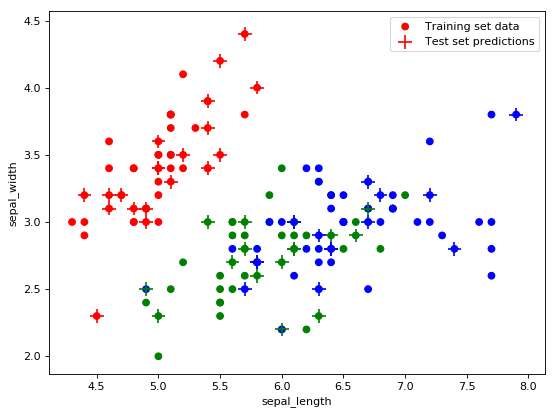

In [28]:
colors_iris = iris.iloc[:,-1].copy()
colors_iris.loc[colors_iris == "Iris_setosa"] = "r"
colors_iris.loc[colors_iris == "Iris_versicolor"] = "g"
colors_iris.loc[colors_iris == "Iris_virginica"] = "b"
colors_test = test_set_pred.iloc[:,-1].copy()
colors_test.loc[colors_test == "Iris_setosa"] = "r"
colors_test.loc[colors_test == "Iris_versicolor"] = "g"
colors_test.loc[colors_test == "Iris_virginica"] = "b"
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.scatter(iris.iloc[:,0], iris.iloc[:,1],color=colors_iris)
ax.scatter(test_set.iloc[:,0], test_set.iloc[:,1], color=colors_test, marker="+", s=150)
ax.legend(labels=["Training set data", "Test set predictions"])
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

## Plotting the decision surfaces:

We will use the features *sepal_length* and *sepal_width* for visualization purposes. To plot the decision boundaries, we first need to compute a grid with all possible combinations of *sepal_length* and *sepal_width* and evaluate our prediction function on this grid. We can then color the regions where the predicted class is the same to visualize the decision boundaries.

### Iris dataset: discrete case

In [29]:
def grid(xRange, yRange, step):
    """ Function to construct an artificial test set which cover the whole planen,  given  a range (xRange, yRange) and with the given precision (step). """ 

    # Create meshgrid
    x = np.arange(xRange[0], xRange[1], step)
    y = np.arange(yRange[0], yRange[1], step)
    X, Y = np.meshgrid(x, y)

    return X, Y

In [30]:
sepal_length_range = [iris.iloc[:,0].min(), iris.iloc[:,0].max()]
sepal_width_range = [iris.iloc[:,1].min(), iris.iloc[:,1].max()]
print(sepal_length_range)
print(sepal_width_range)

[4.3, 7.9]
[2.0, 4.4]


In [52]:
X, Y = grid(sepal_length_range, sepal_width_range, 0.1)
values = pd.DataFrame(np.column_stack((np.hstack(X), np.hstack(Y))))

We train the model on the entire *Iris* dataset this time:

In [53]:
labels, train_set, test_set, split_dataset, pr, probas = train_discr(iris, 0.67)

In [54]:
post = np.zeros((values.shape[0], len(labels)))
for i in range(values.shape[0]):
    post[i, :] = posterior_discr(values.iloc[i,:], pr, labels, probas)
pred_class = predict_class_discr(post)

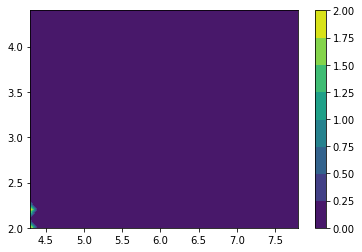

In [55]:
pred_class = np.reshape(pred_class, (X.shape[0], X.shape[1]))
plt.contourf(X,Y,pred_class)
plt.colorbar()
plt.show()

The same problem of class prediction as when the *Iris* data is considered as discrete arises here, since the discretized NB sets many posteriors to 0 and thus classifies most points as having probability 0. The contour plot shows that almost all grid points are classified as 0 (Iris_setosa).

### Iris dataset: continuous case

In [45]:
mean, var = mean_var_by_class(iris, labels)
mean = mean[:,:2]
var = var[:,:2]

In [46]:
post = np.zeros((values.shape[0], len(labels)))
for i in range(values.shape[0]):
    post[i, :] = posterior_cont(values.iloc[i,:], pr, mean, var, labels)
pred_class = predict_class_cont(post)

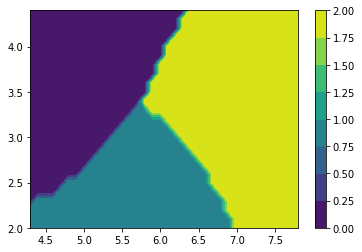

In [50]:
pred_class = np.reshape(pred_class, (X.shape[0], X.shape[1]))
plt.contourf(X,Y,pred_class)
plt.colorbar()
plt.show()

We see that this method has piece-wise (almost) linear boudaries. 

## Remarks:

We started by assuming the *Iris* data was normally distributed and the features conditionally independent. The below plots show the histograms of the iris data by feature. We clearly see that the normality assumption is not very good (apart for *sepal width*). However, the classifier performs well even though one might question this assumption. Furthermore, although the independence assumption simplifies the posterior computation, one might wonder whether the length of a petal is really independent from it's width?

**Bins for IRIS**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11520f6d8>,
      dtype=object)

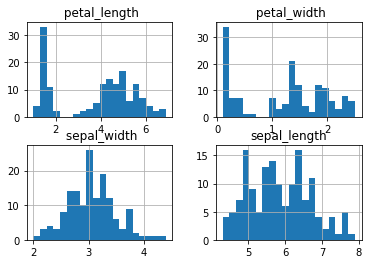

In [56]:
iris.hist(bins=20)

## Conclusion:

In conclusion, the implementation of the NB classifier on discrete and continuous data has given mixed results. The classifier works best on continuous data that is assumed normally distributed and whose features are independent (although these assumptions are a bit simplistic). The misclassification rate is around 30-40% for the *Titanic* dataset (discrete), around 60% for the *Iris* dataset (discrete) and less than 10% for *Iris* (continuous). This method has shown to be sensitive to priors, in the sense that a training set containing over-represented classes will strongly bias the predictions towards these classes. One must thus ensure adequate measures for the random sampling of the entire dataset to construct a training set. The discrete *Iris* dataset showed that discretization can produce bad results if not undertaken appropriately. In the case of a small dataset, some test set features will be assigned probability 0 if the training set doesn't contain the same values and will result in a high missclassification rate. One might think about placing the observations into bins as an extension of this technique to deal with this issue. Finally, the NB classifier produced the best results on the *Iris* dataset when the features were assumed independent and normally distributed. Even though these assumptions don't always hold, one can consider alternative parametric distributions or implement non-parametric estimation methods to increase classification accuracy.

The decision boundary results are in line with the previous comments, with the best results coming from the continuous *Iris* data. The boundaries are estimated to be piece-wise linear.